# Rec Sys
Hands on Recommender Systems

# Problem & Data - Problem Definition & Data Generation Strategy

## The problem

### Problem statement

The problem we aim to solve is:

> Create an engine to let restaurants know the food delivery preferences of possible clients when they buy through a food delivery platform and whose purchase intention is driven by the ocassion of movie streaming.

There are several assumptions to be made before we solve this problem, but the grounding ones are:

1. **We assume that when clients receive a movie recommendation, they are highly likely to watch it the same day.** That is to say, we are not going to assign probabilities to watch the recommended movie, we assume that probability to be 1.
2. **We assume that food delivery preferences can be closely related to the movie the clients are likely to see**. That is to say, we assume that when clients choose a movie to watch, they are also oriented to choose a meal to accompany the movie, and vice versa.
3. **We assume there is a partnership between the food delivery platform and the movie streaming service**.

### Why this problem matters?

Suppose that the partnership between the food delivery platform and the movie streaming service one day comes to reality.

If assumptions 1 and 2 are real (at least if we can compute those probabilities), then all parties would have potential benefits:

1. The movie streaming service would not only have more data to clasify customers, but would also provide inside their platform personalized promotions at the customer level with the food preferences of their clients, increasing the engament of the clients to the platform due to the platform itself provides an enhanced experience when binding together movies clients want to watch with the consecuent meal they want to eat while watching the movie.
2. Food delivery platform would increase the sellings and reduce the time clients waste trying to decide what to buy.
3. At the end of the chain, if restaurants have a prior of what clients want to see, they can adjust their strategies of online promotions (supported by food delivery service), and this would benefit the restaurant also to adjust their inventory and capacity to meet the demand.

### The purpuse behind the project

The main purpose of this project is to provide hands-on experience on [kedro](https://docs.kedro.org/en/stable/introduction/index.html) while working in a well known problem: **Recommender Systems**.

> Kedro is an open-source Python framework to create reproducible, maintainable, and modular data science code. It uses software engineering best practices to help you build production-ready data science pipelines.

For the sake of simplicity, is better to work with a simple and well known problem: *a movie recommender system*.

The innovation comes when linking it to the hypothetical partnership between the food delivery platform and the movie streaming service.

## Data Generation approach

**Objective:** Create or synthesize a realistic dataset (minimum 1,000 samples)

### Define the functions to use

In [1]:
from typing import BinaryIO
import requests
import zipfile
import os
from io import BytesIO
from urllib.parse import urlparse
from pathlib import Path

In [2]:
def is_url_a_zip(url: str) -> tuple[bool, str]:
    """
    Checks if a file at a given URL is likely a ZIP file based on its extension
    and/or HTTP Content-Type header.

    Args:
        url (str): The URL of the file.

    Returns:
        bool: True if the file is likely a ZIP, False otherwise.
        str: A message explaining the result.
    """
    # Method 1: Check file extension from URL
    parsed_url = urlparse(url)
    path = parsed_url.path
    file_extension = os.path.splitext(path)[1].lower()

    if file_extension == ".zip":
        return True, f"Based on URL extension: '{file_extension}', it appears to be a ZIP file."

    # Method 2: Check Content-Type header
    try:
        # Use a HEAD request to get headers without downloading the full content
        response = requests.head(url, allow_redirects=True, timeout=5)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        content_type = response.headers.get('Content-Type', '').lower()
        print(f"DEBUG: Content-Type for {url}: {content_type}") # For debugging

        if 'application/zip' in content_type or 'application/x-zip-compressed' in content_type:
            return True, f"Based on Content-Type header: '{content_type}', it is identified as a ZIP file."
        else:
            return False, f"Content-Type header '{content_type}' does not indicate a ZIP file."

    except requests.exceptions.RequestException as e:
        return False, f"Could not check URL due to network error or invalid URL: {e}"
    except Exception as e:
        return False, f"An unexpected error occurred: {e}"

In [3]:
# --- Test cases ---
zip_url_1 = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
not_zip_url_1 = "https://www.google.com"
not_zip_url_2 = "https://example.com/document.pdf"
zip_url_with_redirect = "http://speedtest.tele2.net/1MB.zip" # Example that might redirect

print(f"Checking URL: {zip_url_1}")
is_zip, message = is_url_a_zip(zip_url_1)
print(f"Result: {is_zip} - {message}\n")

print(f"Checking URL: {not_zip_url_1}")
is_zip, message = is_url_a_zip(not_zip_url_1)
print(f"Result: {is_zip} - {message}\n")

print(f"Checking URL: {not_zip_url_2}")
is_zip, message = is_url_a_zip(not_zip_url_2)
print(f"Result: {is_zip} - {message}\n")

print(f"Checking URL (with potential redirect): {zip_url_with_redirect}")
is_zip, message = is_url_a_zip(zip_url_with_redirect)
print(f"Result: {is_zip} - {message}\n")

Checking URL: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Result: True - Based on URL extension: '.zip', it appears to be a ZIP file.

Checking URL: https://www.google.com
DEBUG: Content-Type for https://www.google.com: text/html; charset=iso-8859-1
Result: False - Content-Type header 'text/html; charset=iso-8859-1' does not indicate a ZIP file.

Checking URL: https://example.com/document.pdf
Result: False - Could not check URL due to network error or invalid URL: 404 Client Error: Not Found for url: https://example.com/document.pdf

Checking URL (with potential redirect): http://speedtest.tele2.net/1MB.zip
Result: True - Based on URL extension: '.zip', it appears to be a ZIP file.



In [4]:
def download_zip_file(zip_url: str) -> tuple[BinaryIO, str]:
    """
    Downloads a ZIP file from zip_url

    Args:
        zip_url (str): A URL to download the ZIP file.

    Returns:
        zip_content (BinaryIO): Binary content of the ZIP file.
        zip_file_name (str): The name of the ZIP file.
    """
    # Check the provided url is a ZIP file
    is_zip, message = is_url_a_zip(zip_url)

    if is_zip:
        print(f"Downloading the ZIP file from {zip_url} ...")
    
        # Parse the URL
        parsed_url = urlparse(zip_url)
        
        # Get the path component of the URL
        path = parsed_url.path
        
        # Extract the base filename from the path
        zip_file_name = os.path.basename(path)
        
        print(f"The zip file name is: {zip_file_name}")
    
        try:
            response = requests.get(zip_url, stream=True)
            response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
        
            # Save the zip file to a temporary location or directly process it in memory
            # For large files, streaming to disk is better. For this small file, in-memory is fine.
            # We'll use BytesIO to handle it in memory for simplicity here.
            zip_content = BytesIO(response.content)
            print("Download complete.")
            return zip_content, zip_file_name
    
        except requests.exceptions.RequestException as e:
            raise RuntimeError(f"Error downloading the file: {e}") from e
    else:
        raise ValueError(f"The url provided {zip_url} doesn't correspond to a ZIP file. {message}")

In [5]:
def extract_zip_content(zip_content: BinaryIO, zip_file_name: str, extract_to_dir: str):
    """
    Extract the content from zip_content into extract_to_dir path.

    Args:
        zip_content (BinaryIO): Binary content of the ZIP file.
        zip_file_name (str): The name of the ZIP file.
        extract_to_dir (str): Path to extract ZIP fle content.
    """
    print(f"Unzipping {zip_file_name} to {extract_to_dir} ...")
    try:        
        # Create the directory if it doesn't exist
        os.makedirs(extract_to_dir, exist_ok=True)

        with zipfile.ZipFile(zip_content, 'r') as zip_ref:
            zip_ref.extractall(extract_to_dir)
        print("Unzipping complete.")
    except zipfile.BadZipFile as e:
        raise ValueError(f"Error: The downloaded file '{zip_file_name}' is not a valid zip file.") from e
        exit()
    except Exception as e:
        raise RuntimeError(f"An error occurred during unzipping: {e}") from e

### [Download] Movies dataset

The starting point is to get a suitable movies dataset.

A trusted source recommended for education and development is the [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/).

The dataset consists of movies metadata which include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

There are two datasets:

- Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.
- Full: approximately 33,000,000 ratings and 2,000,000 tag applications applied to 86,000 movies by 330,975 users. Includes tag genome data with 14 million relevance scores across 1,100 tags. Last updated 9/2018.

> These datasets were collected by **GroupLens Research** from the [MovieLens web site](https://movielens.org). See [MovieLens](https://grouplens.org/datasets/movielens/) for other datasets.

For exploration, we are going to use the small one.

In [6]:
# Define the URL and the target directory for extraction
zip_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
extract_to_dir = "../data/01_raw/movielens_data"

zip_content, zip_file_name = download_zip_file(zip_url)
extract_zip_content(zip_content, zip_file_name, extract_to_dir)

The zip file name is: ml-latest-small.zip
Download complete.
Unzipping ml-latest-small.zip to ../data/01_raw/movielens_data ...
Unzipping complete.


### [Download] Online Food Delivery Preferences Dataset

In Kaggle you can find a dataset called [Online Food Delivery Preferences-Bangalore region](https://www.kaggle.com/datasets/benroshan/online-food-delivery-preferencesbangalore-region)
which aims to assess online food delivery demand in Bangalore, India.

The dataset has nearly 55 variables based on the following titles

- Demographics of consumers
- Overall/general purchase decision
- Time of delivery influencing the purchase decision
- Rating of Restaurant influencing the purchase decision

> The dataset was collected by [Ben Roshan](https://www.kaggle.com/benroshan) as part of his masters thesis.


In [7]:
# Define the URL and the target directory for extraction
zip_url = "https://www.kaggle.com/api/v1/datasets/download/benroshan/online-food-delivery-preferencesbangalore-region"
extract_to_dir = "../data/01_raw/online_food_delivery_preferences"

zip_content, zip_file_name = download_zip_file(zip_url)
extract_zip_content(zip_content, zip_file_name, extract_to_dir)

ValueError: The url provided https://www.kaggle.com/api/v1/datasets/download/benroshan/online-food-delivery-preferencesbangalore-region doesn't correspond to a ZIP file. Could not check URL due to network error or invalid URL: 404 Client Error: Not Found for url: https://www.kaggle.com/api/v1/datasets/download/benroshan/online-food-delivery-preferencesbangalore-region

I have found a problem with the function I built before. That function doesn't take into account that the url to download file could lack of `file_extension`.

In order to handle this edge case, I will modify the functions to omit file verification:

In [8]:
def check_url_is_a_zip_from_header(url: str) -> tuple[bool, str]:
    """
    Checks if a file at a given URL is likely a ZIP file based on its
    HTTP Content-Type header.

    Args:
        url (str): The URL of the file.

    Returns:
        bool: True if the file is likely a ZIP, False otherwise.
        str: A message explaining the result.
    """
    # Check Content-Type header
    try:
        # Use a HEAD request to get headers without downloading the full content
        response = requests.head(url, allow_redirects=True, timeout=5)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

        content_type = response.headers.get('Content-Type', '').lower()
        print(f"DEBUG: Content-Type for {url}: {content_type}") # For debugging

        if 'application/zip' in content_type or 'application/x-zip-compressed' in content_type:
            return True, f"Based on Content-Type header: '{content_type}', it is identified as a ZIP file."
        else:
            return False, f"Content-Type header '{content_type}' does not indicate a ZIP file."

    except requests.exceptions.RequestException as e:
        return False, f"Could not check URL due to network error or invalid URL: {e}"
    except Exception as e:
        return False, f"An unexpected error occurred: {e}"

In [9]:
def download_file_from_url(url: str, omit_verification: bool = False) -> tuple[BinaryIO, str]:
    """
    Downloads a ZIP file from url

    Args:
        url (str): A URL to download the ZIP file.
        omit_verification (bool): If True, omits the verification of the file extension within the URL.

    Returns:
        url_content (BinaryIO): Binary content of the ZIP file.
        file_name (str): The name of the ZIP file.
    """
    # Parse the URL
    parsed_url = urlparse(url)
    
    # Get the path component of the URL
    path = Path(parsed_url.path)
    
    # Extract the base filename from the path
    file_name = path.name
    
    print(f"The file name is: {file_name}")


    print(f"Downloading the file from {url} ...")

    if omit_verification:
        # If verification is omitted, we assume the file is a ZIP
        is_zip = True
        message = "Verification of the file type is omitted, assuming it is a ZIP file."
        print("Omitting verification of the file type based on URL extension.")
    else:
        # Check if the URL corresponds to a ZIP file

        # Check file extension from URL path
        file_extension = path.suffix.lower()

        match file_extension:
        # Determine if the file is a ZIP based on its extension
            case ".zip":
                is_zip = True
                message = f"Based on URL extension: '{file_extension}', it appears to be a ZIP file."
            case "":
                is_zip = False
                message = "The URL does not have a file extension, cannot determine if it is a ZIP file."
            case _:
                if "." in file_extension:
                    is_zip = False
                    message = f"Based on URL extension: '{file_extension}', it does not appear to be a ZIP file."
                else:
                    print(f"Based on URL extension: '{file_extension}', it does not appear to be a ZIP file. Verifying via Content-Type header...")
                    is_zip, message = check_url_is_a_zip_from_header(url)

    # If the file extension is .zip or if we are omitting verification, proceed with downloading    
    if is_zip or omit_verification:
        print(f"File verification: {message}")
        # Proceed with downloading the file   
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)
        
            # Save the zip file to a temporary location or directly process it in memory
            # For large files, streaming to disk is better. For this small file, in-memory is fine.
            # We'll use BytesIO to handle it in memory for simplicity here.
            url_content = BytesIO(response.content)
            print("Download complete.")
            return url_content, file_name
    
        except requests.exceptions.RequestException as e:
            raise RuntimeError(f"Error downloading the file: {e}") from e
        except TypeError as e:
            raise ValueError(f"Invalid URL: {url}. Error: {e}") from e
    else:
        raise ValueError(f"The url provided {url} doesn't correspond to a ZIP file. {message}")

The above implementation attempts to account for borderline cases that could occur, but it is not ruled out that there may be others not considered.
In any case, if the `url_content` downloaded is not a ZIP file, the function `extract_zip_content` will fail and raise the corresponding exception.

In [10]:
# Define the URL and the target directory for extraction
url = "https://www.kaggle.com/api/v1/datasets/download/benroshan/online-food-delivery-preferencesbangalore-region"
extract_to_dir = "../data/01_raw/online_food_delivery_preferences"

url_content, file_name = download_file_from_url(url, omit_verification=True)
extract_zip_content(url_content, file_name, extract_to_dir)

The file name is: online-food-delivery-preferencesbangalore-region
Omitting verification of the file type based on URL extension.
File verification: Verification of the file type is omitted, assuming it is a ZIP file.
Download complete.
Unzipping online-food-delivery-preferencesbangalore-region to ../data/01_raw/online_food_delivery_preferences ...
Unzipping complete.


### Data preprocessing

Once downloaded the data, we proceed to include an appropriate data preprocessing and quality handling

In [11]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
pd.set_option("display.max_columns", None)  # Show all columns in DataFrame

#### Quick Exploration

##### Movies Dataset

**User Ids**

MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).


**Movie Ids**

Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).


**Links Data File Structure (links.csv)**

Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,imdbId,tmdbId

movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.


In [13]:
links_df = pd. read_csv("../data/01_raw/movielens_data/ml-latest-small/links.csv")
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


> **Comments**
>
> These identifiers to IMDB and TMDB platforms would be useful if in the future we decide to use their APIs, for example [TMDB's API](https://developer.themoviedb.org/reference/intro/getting-started), in order to enrich our data using their public data.
>
> For example, TMDB's API has a dedicated section to give us additional [movie details](https://developer.themoviedb.org/reference/movie-details) information like
> posters, backdrops, budget, revenue, release dates, languages, production countries and companies.
>
> For the sake of simplicity, we won't use it now.

**Movies Data File Structure (movies.csv)**

Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list, and are selected from the following:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)


In [14]:
movies_df = pd. read_csv("../data/01_raw/movielens_data/ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


> **Comments**
>
> It is useful to have `genres` for each movie in order to construct a feature-based recommender system.

**Ratings Data File Structure (ratings.csv)**

All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

    userId,movieId,rating,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [15]:
ratings_df = pd. read_csv("../data/01_raw/movielens_data/ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
# Show the number of unique users and movies
print("Number of unique users:", ratings_df['userId'].nunique())
print("Number of unique movies:", ratings_df['movieId'].nunique())

Number of unique users: 610
Number of unique movies: 9724


<Axes: xlabel='rating'>

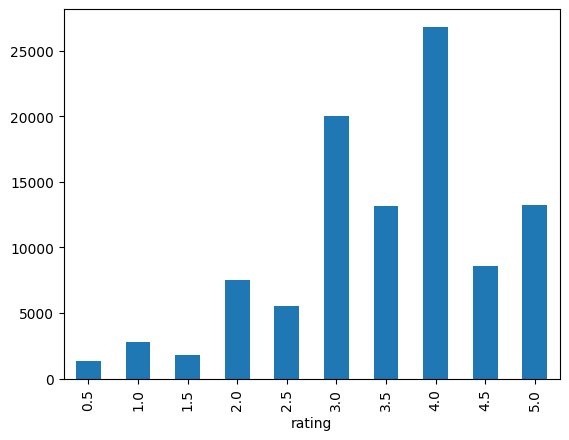

In [17]:
# Check the unique ratings
ratings_df["rating"].unique()
ratings_df["rating"].value_counts().sort_index().plot(kind="bar")

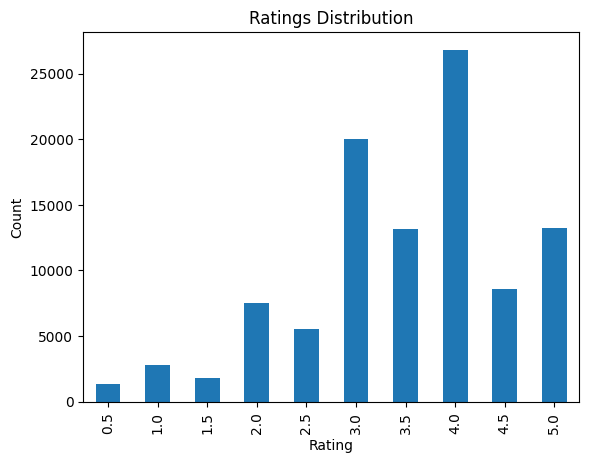

In [18]:
ratings_df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

> **Comments**
>
> `ratings` is our key variable to look for.


**Tags Data File Structure (tags.csv)**

All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

The lines within this file are ordered first by userId, then, within user, by movieId.

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [19]:
tags_df = pd. read_csv("../data/01_raw/movielens_data/ml-latest-small/tags.csv")
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


> **Comments**
>
> `tag` variable is subjective to each user, and it is supposed that `ratings` already accounts for this subjectivity. For the sake of simplicity won't use it 

> **Comments**
>
> The simplest recommender engine can be based purely in `genres` and `ratings`. Let's explore this approach.

##### Delivery Dataset

It has the following fields:

| column index | column name | Description |
| ------------ | ----------- | ----------- |
| 0 | Age | Age of Consumer |
| 1 | Gender | Gender of Consumer |
| 2 | Marital Status | Marital Status of Consumer |
| 3 |Occupation | Job or Occupation status of Consumer |
| 4 |Monthly Income | Income bracket of consumer |
| 5 |Educational Qualifications | Education of consumer |
| 6 |Family size | Number of family members/ friends living with |
| 7 |latitude | latitude of residence |
| 8 |longitude | longitude of residence |
| 9 | Pin code | pincode of residence in Bangalore |
| 10 | Medium (P1) | Medium of order(Preference 1) |
| 11 | Medium (P2) | Medium of order(Preference 2) |
| 12 | Meal(P1) | Type of meal order(Preference 1) |
| 13 | Meal(P2) | Type of meal order(Preference 2) |
| 14 | Perference(P1) | Cuisine (Preference 1) |
| 15 | Perference(P2) | Cuisine (Preference 2) |
| 16 | Ease and convenient | Ease and convenience of online ordering |
| 17 | Time saving | Does it save time ? |
| 18 | More restaurant choices | More restaurant choice influences |
| 19 | Easy Payment option | Payment option influences |
| 20 | More Offers and Discount | Offers and discount influences |
| 21 | Good Food quality | Food quality influences |
| 22 | Good Tracking system | Tracking system influences |
| 23 | Self Cooking | Self cooking causes not purchasing |
| 24 | Health Concern | Health concern causes not purchasing |
| 25 | Late Delivery | Later Delivery causes not purchasing |
| 26 | Poor Hygiene | Poor Hygiene causes not purchasing |
| 27 | Bad past experience | Past experiences causes not purchasing |
| 28 | Unavailability | Unavailability causes not purchasing |
| 29 | Unaffordable | Un-affordability causes not purchasing |
| 30 | Long delivery time | Long delivery causes cancellation |
| 31 | Delay of delivery person getting assigned | Delay of delivery person assigned causes cancellation |
| 32 | Delay of delivery person picking up food | Delay of delivery person waiting at restaurant causes cancellation |
| 33 | Wrong order delivered | Previous wrong order causes cancellation |
| 34 | Missing item | Missing item in order causes cancellation |
| 35 | Order placed by mistake | Placed order by mistake causes cancellation |
| 36 | Influence of time | Is there any influence in time ? |
| 37 | Order Time | When do you order? |
| 38 | Maximum wait time | How long can you wait ? |
| 39 | Residence in busy location | Residence in busy location |
| 40 | Google Maps Accuracy | My location in google maps is accurate |
| 41 | Good Road Condition | My residence area road condition is good |
| 42 | Low quantity low time | low quantity low delivery time |
| 43 | Delivery person ability | Delivery person ability depends on time of delivery |
| 44 | Influence of rating | Is there any influence in restaurant rating ? |
| 45 | Less Delivery time | Importance of Less delivery time |
| 46 | High Quality of package | Importance of Quality of package |
| 47 | Number of calls | Importance of Number of calls made by delivery captain |
| 48 | Politeness | Importance of Politeness of delivery captain |
| 49 | Freshness | Importance of Freshness of food |
| 50 | Temperature | Importance of Temperature of food |
| 51 | Good Taste | Importance of taste |
| 52 | Good Quantity | Importance of Quantity in food |
| 53 | Output | Will I purchase again ? |
| 54 | Reviews | Feedback on online delivery services |

In [20]:
delivery_data_df = pd.read_csv("../data/01_raw/online_food_delivery_preferences/onlinedeliverydata.csv")
delivery_data_df.head(10)  # Display the first 10 rows of the DataFrame

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Medium (P1),Medium (P2),Meal(P1),Meal(P2),Perference(P1),Perference(P2),Ease and convenient,Time saving,More restaurant choices,Easy Payment option,More Offers and Discount,Good Food quality,Good Tracking system,Self Cooking,Health Concern,Late Delivery,Poor Hygiene,Bad past experience,Unavailability,Unaffordable,Long delivery time,Delay of delivery person getting assigned,Delay of delivery person picking up food,Wrong order delivered,Missing item,Order placed by mistake,Influence of time,Order Time,Maximum wait time,Residence in busy location,Google Maps Accuracy,Good Road Condition,Low quantity low time,Delivery person ability,Influence of rating,Less Delivery time,High Quality of package,Number of calls,Politeness,Freshness,Temperature,Good Taste,Good Quantity,Output,Reviews
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Food delivery apps,Web browser,Breakfast,Lunch,Non Veg foods (Lunch / Dinner),Bakery items (snacks),Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Agree,Agree,Agree,Agree,Agree,Agree,Yes,Weekend (Sat & Sun),30 minutes,Agree,Neutral,Neutral,Neutral,Neutral,Yes,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Moderately Important,Yes,Nil\n
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Food delivery apps,Web browser,Snacks,Dinner,Non Veg foods (Lunch / Dinner),Veg foods (Breakfast / Lunch / Dinner),Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Neutral,Agree,Strongly agree,Strongly agree,Agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Strongly agree,Yes,Anytime (Mon-Sun),30 minutes,Strongly Agree,Neutral,Disagree,Strongly disagree,Agree,Yes,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Yes,Nil
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Food delivery apps,Direct call,Lunch,Snacks,Non Veg foods (Lunch / Dinner),Ice cream / Cool drinks,Strongly agree,Strongly agree,Strongly agree,Neutral,Neutral,Disagree,Neutral,Disagree,Neutral,Neutral,Agree,Agree,Agree,Agree,Agree,Agree,Agree,Strongly agree,Agree,Neutral,Yes,Anytime (Mon-Sun),45 minutes,Agree,Strongly Agree,Neutral,Neutral,Agree,Yes,Important,Very Important,Moderately Important,Very Important,Very Important,Important,Very Important,Moderately Important,Yes,"Many a times payment gateways are an issue, so..."
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Food delivery apps,Walk-in,Snacks,Dinner,Veg foods (Breakfast / Lunch / Dinner),Bakery items (snacks),Agree,Agree,Strongly agree,Agree,Strongly agree,Agree,Agree,Agree,Strongly agree,Neutral,Agree,Disagree,Disagree,Neutral,Agree,Agree,Agree,Disagree,Disagree,Neutral,Yes,Anytime (Mon-Sun),30 minutes,Disagree,Agree,Agree,Neutral,Agree,Yes,Very Important,Important,Moderately Important,Very Important,Very Important,Very Important,Very Important,Important,Yes,nil
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Walk-in,Direct call,Lunch,Dinner,Non Veg foods (Lunch / Dinner),Veg foods (Breakfast / Lunch / Dinner),Agree,Agree,Agree,Agree,Agree,Neutral,Neutral,Agree,Strongly agree,Strongly agree,Agree,Strongly agree,Agree,Disagree,Strongly agree,Strongly agree,Neutral,Neutral,Neutral,Disagree,Yes,Weekend (Sat & Sun),30 minutes,Agree,Agree,Agree,Agree,Agree,Yes,Important,Important,Moderately Important,Important,Important,Important,Very Important,Very Important,Yes,NIL
5,27,Female,Married,Employee,More than 50000,Post Graduate,2,12.9299,77.6848,560103,Food delivery apps,Walk-in,Lunch,Dinner,Non Veg foods (L

In [21]:
delivery_data_df.shape

(388, 55)

> **Comments**
>
> Remember this dataset contains information about customers, their purchase intention and different insights about the purchase influencing facts.
> As you can see, we have information about 388 customers.
> 
> The data is distributed in the following columns:
> 
> - Demographics of consumers: columns from 0 to 9
> - Overall/general purchase decision: columns from 10 to 15
>
> And the rest of the columns are related to **Time of delivery influencing the purchase decision** and **Rating of Restaurant influencing the purchase decision**.
> We are going to get rid of these last columns, again, for the sake of simplicity.

> **Comments**
> 
> The idea now, is to forget the fact that the data is from Bangalore, India. Thus we can also get rid of `Pin code` (column 9).
>
> The strong assumption we are going to make is that we can assign the data about demographics and purchase decision of the 388 customers to the 610 users in movies dataset.

#### Movies Dataset Preprocessing

> **Comments**
>
> For the sake of simplicity, we are going to perform one-hot encoding over all categorical variables, so that we can calculate distances using these variables.

In [22]:
# Function to perform one-hot encoding for categorical columns using scikit-learn
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Perform one-hot encoding on specified columns of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to encode.
        columns (list[str]): List of column names to encode.

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded columns.
    """
    encoder = OneHotEncoder(sparse_output=False, dtype=int)
    encoded_columns = encoder.fit_transform(df[columns])
    
    # Create a DataFrame with the encoded columns
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns))
    
    # Concatenate the original DataFrame with the encoded DataFrame
    df_encoded = pd.concat([df.drop(columns=columns), encoded_df], axis=1)

    return df_encoded, encoder

In [23]:
# Rename columns for consistency and good practice according to python conventions
ratings_df = ratings_df.rename(columns={"userId": "user_id", "movieId": "movie_id"})
movies_df = movies_df.rename(columns={"movieId": "movie_id"})

In [24]:
# Merge ratings with movies to get movie titles
ratings_with_titles_df = pd.merge(ratings_df, movies_df, on="movie_id", how="left")

# Display the first few rows of the merged DataFrame
ratings_with_titles_df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [25]:
ratings_with_titles_df.head()

,user_id,movie_id,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [26]:
# Format time column to datetime
ratings_with_titles_df['timestamp'] = pd.to_datetime(ratings_with_titles_df['timestamp'], unit='s')

# Explode the genres column into multiple rows
ratings_with_titles_df['genres'] = ratings_with_titles_df['genres'].str.split('|')
ratings_with_titles_df = ratings_with_titles_df.explode('genres', ignore_index=True)

# Perform one-hot encoding on the genres column
ratings_with_titles_df_encoded, movies_encoder = one_hot_encode(ratings_with_titles_df, ['genres'])

# Gropuby the same user and movie, and aggregate the ratings by taking the max
ratings_with_titles_df_encoded = ratings_with_titles_df_encoded.groupby(['user_id', 'movie_id', 'title', 'timestamp']).max().reset_index()

# Display the first few rows of the DataFrame with formatted timestamp
ratings_with_titles_df_encoded.head()

,user_id,movie_id,title,timestamp,rating,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,1,1,Toy Story (1995),2000-07-30 18:45:03,4.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,3,Grumpier Old Men (1995),2000-07-30 18:20:47,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,Heat (1995),2000-07-30 18:37:04,4.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),2000-07-30 19:03:35,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,"Usual Suspects, The (1995)",2000-07-30 18:48:51,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [27]:
# Show minimum and maximum timestamps
print("Minimum timestamp:", ratings_with_titles_df_encoded['timestamp'].min())
print("Maximum timestamp:", ratings_with_titles_df_encoded['timestamp'].max())

# Show the number of unique users and movies
print("Number of unique users:", ratings_with_titles_df_encoded['user_id'].nunique())
print("Number of unique movies:", ratings_with_titles_df_encoded['movie_id'].nunique())

Minimum timestamp: 1996-03-29 18:36:55
Maximum timestamp: 2018-09-24 14:27:30
Number of unique users: 610
Number of unique movies: 9724


In [28]:
print("Min user_id:", ratings_with_titles_df['user_id'].min())

Min user_id: 1


#### Delivery Dataset Preprocessing

In [29]:
delivery_data_df.columns[:16].tolist() # Display the first 16 column names

['Age',
 'Gender',
 'Marital Status',
 'Occupation',
 'Monthly Income',
 'Educational Qualifications',
 'Family size',
 'latitude',
 'longitude',
 'Pin code',
 'Medium (P1)',
 'Medium (P2)',
 'Meal(P1)',
 'Meal(P2)',
 'Perference(P1)',
 'Perference(P2)']

In [30]:
# Select relevant columns for delivery data
# Columns from 0 to 15 are selected and column 9 is dropped
delivery_df = delivery_data_df[delivery_data_df.columns[:9].tolist() + delivery_data_df.columns[10:16].tolist()].copy()  # Select the first 15 columns, dropping the 9th column

# Rename columns for consistency and good practice according to python conventions
# All columns are renamed to lowercase and spaces are replaced with underscores
delivery_df.columns = [col.lower().replace(" ", "_").replace("_(", "_").replace("(", "_").replace(")", "").replace("perference", "preference") for col in delivery_df.columns]

# Display the first few rows of the cleaned delivery DataFrame
delivery_df.head()

,age,gender,marital_status,occupation,monthly_income,educational_qualifications,family_size,latitude,longitude,medium_p1,medium_p2,meal_p1,meal_p2,preference_p1,preference_p2
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,Food delivery apps,Web browser,Breakfast,Lunch,Non Veg foods (Lunch / Dinner),Bakery items (snacks)
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,Food delivery apps,Web browser,Snacks,Dinner,Non Veg foods (Lunch / Dinner),Veg foods (Breakfast / Lunch / Dinner)
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,Food delivery apps,Direct call,Lunch,Snacks,Non Veg foods (Lunch / Dinner),Ice cream / Cool drinks
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,Food delivery apps,Walk-in,Snacks,Dinner,Veg foods (Breakfast / Lunch / Dinner),Bakery items (snacks)
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,Walk-in,Direct call,Lunch,Dinner,Non Veg foods (Lunch / Dinner),Veg foods (Breakfast / Lunch / Dinner)


In [31]:
delivery_df.shape  # Display the shape of the DataFrame

(388, 15)

In [32]:
# Explore categorical columns for one-hot encoding
delivery_df.columns[1:6].tolist()

['gender',
 'marital_status',
 'occupation',
 'monthly_income',
 'educational_qualifications']

In [33]:
# Explore categorical columns for one-hot encoding
delivery_df.columns[9:].tolist()

['medium_p1',
 'medium_p2',
 'meal_p1',
 'meal_p2',
 'preference_p1',
 'preference_p2']

In [34]:
categorical_cols = delivery_df.columns[1:6].tolist() + delivery_df.columns[9:].tolist()

In [35]:
# Perform one-hot encoding for categorical columns using the defined function
delivery_df_encoded, delivery_encoder = one_hot_encode(delivery_df, columns=categorical_cols)

delivery_df_encoded.head()  # Display the first few rows of the encoded DataFrame

,age,family_size,latitude,longitude,gender_Female,gender_Male,marital_status_Married,marital_status_Prefer not to say,marital_status_Single,occupation_Employee,occupation_House wife,occupation_Self Employeed,occupation_Student,monthly_income_10001 to 25000,monthly_income_25001 to 50000,monthly_income_Below Rs.10000,monthly_income_More than 50000,monthly_income_No Income,educational_qualifications_Graduate,educational_qualifications_Ph.D,educational_qualifications_Post Graduate,educational_qualifications_School,educational_qualifications_Uneducated,medium_p1_Direct call,medium_p1_Food delivery apps,medium_p1_Walk-in,medium_p1_Web browser,medium_p2_ Direct call,medium_p2_ Walk-in,medium_p2_ Web browser,meal_p1_Breakfast,meal_p1_Dinner,meal_p1_Lunch,meal_p1_Snacks,meal_p2_ Dinner,meal_p2_ Lunch,meal_p2_ Snacks,preference_p1_Bakery items (snacks),preference_p1_Non Veg foods (Lunch / Dinner),preference_p1_Sweets,preference_p1_Veg foods (Breakfast / Lunch / Dinner),preference_p2_ Bakery items (snacks),preference_p2_ Ice cream / Cool drinks,preference_p2_ Sweets,preference_p2_ Veg foods (Breakfast / Lunch / Dinner)
0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,24,3,12.9770,77.5773,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1
2,22,3,12.9551,77.6593,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,22,6,12.9473,77.5616,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0
4,22,4,12.9850,77.5533,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1


In [36]:
delivery_df_encoded.shape  # Display the shape of the encoded DataFrame

(388, 45)

> **Comments**
>
> Without loss of generality and for reasons of time, we are going to assign the data above to the first 388 `user_id` of **movies dataset**, getting rid of the remaining 222 `user_id`.

In [37]:
# Create a new column 'user_id' with the same value of the index of delivery_df_encoded
delivery_df_encoded["user_id"] = delivery_df_encoded.index + 1  # user_id starts from 1

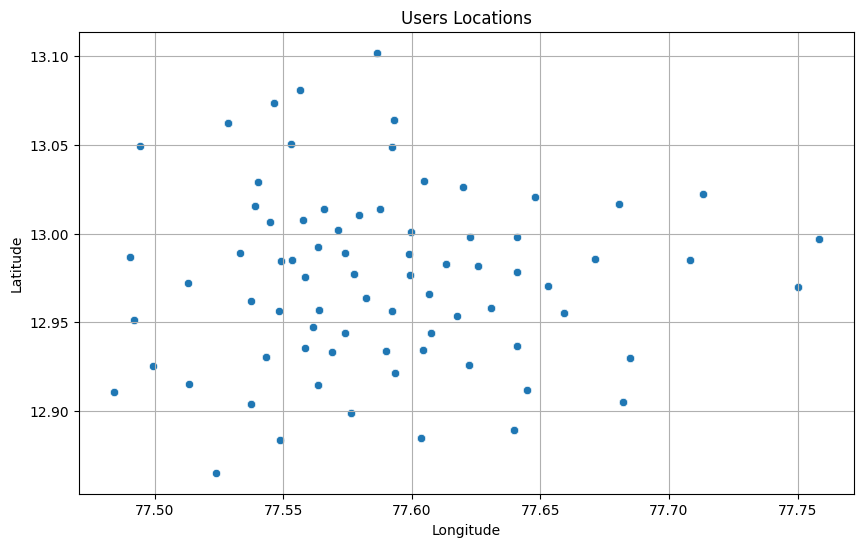

In [38]:
# Plot users locations using latitud and longitude
plt.figure(figsize=(10, 6))
sns.scatterplot(data=delivery_df_encoded, x='longitude', y='latitude')
plt.title("Users Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

#### Full Dataset for modelling

In [39]:
# Merge delivery data with ratings to create a full dataset
full_data_df = pd.merge(ratings_with_titles_df_encoded, delivery_df_encoded, on="user_id", how="inner")

# Display the first few rows of the full dataset
full_data_df.head()

,user_id,movie_id,title,timestamp,rating,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western,age,family_size,latitude,longitude,gender_Female,gender_Male,marital_status_Married,marital_status_Prefer not to say,marital_status_Single,occupation_Employee,occupation_House wife,occupation_Self Employeed,occupation_Student,monthly_income_10001 to 25000,monthly_income_25001 to 50000,monthly_income_Below Rs.10000,monthly_income_More than 50000,monthly_income_No Income,educational_qualifications_Graduate,educational_qualifications_Ph.D,educational_qualifications_Post Graduate,educational_qualifications_School,educational_qualifications_Uneducated,medium_p1_Direct call,medium_p1_Food delivery apps,medium_p1_Walk-in,medium_p1_Web browser,medium_p2_ Direct call,medium_p2_ Walk-in,medium_p2_ Web browser,meal_p1_Breakfast,meal_p1_Dinner,meal_p1_Lunch,meal_p1_Snacks,meal_p2_ Dinner,meal_p2_ Lunch,meal_p2_ Snacks,preference_p1_Bakery items (snacks),preference_p1_Non Veg foods (Lunch / Dinner),preference_p1_Sweets,preference_p1_Veg foods (Breakfast / Lunch / Dinner),preference_p2_ Bakery items (snacks),preference_p2_ Ice cream / Cool drinks,preference_p2_ Sweets,preference_p2_ Veg foods (Breakfast / Lunch / Dinner)
0,1,1,Toy Story (1995),2000-07-30 18:45:03,4.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,1,3,Grumpier Old Men (1995),2000-07-30 18:20:47,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
2,1,6,Heat (1995),2000-07-30 18:37:04,4.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),2000-07-30 19:03:35,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
4,1,50,"Usual Suspects, The (1995)",2000-07-30 18:48:51,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,20,4,12.9766,77.5993,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [40]:
# Show minimum and maximum timestamps
print("Minimum timestamp:", full_data_df['timestamp'].min())
print("Maximum timestamp:", full_data_df['timestamp'].max())

# Show the number of unique users and movies
print("Number of unique users:", full_data_df['user_id'].nunique())
print("Number of unique movies:", full_data_df['movie_id'].nunique())

Minimum timestamp: 1996-04-12 15:19:00
Maximum timestamp: 2018-09-22 20:56:15
Number of unique users: 388
Number of unique movies: 7371


# Model Development - Technical implementation and methodology

## Model 1 - Content-Based Recommender System

This approach computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.

In [41]:
# filter columns to keep only the relevant ones using filtering
content_based_cols = list(filter(lambda x: x.startswith("genres_") or x in ["user_id", "movie_id", "rating", "timestamp", "title"], full_data_df.columns))

# Create a new DataFrame with only the relevant columns for content-based filtering
content_based_df = full_data_df[content_based_cols].copy()

# Display the first few rows of the content-based DataFrame
content_based_df.head()

,user_id,movie_id,title,timestamp,rating,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,1,1,Toy Story (1995),2000-07-30 18:45:03,4.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,3,Grumpier Old Men (1995),2000-07-30 18:20:47,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,6,Heat (1995),2000-07-30 18:37:04,4.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,47,Seven (a.k.a. Se7en) (1995),2000-07-30 19:03:35,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,1,50,"Usual Suspects, The (1995)",2000-07-30 18:48:51,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


The most simple implementation of the Content-Based Recommender System is to take all movies, calculate distances between them and then use top preferences of users to recommend another similar movie.

In addition, this recommended movie will also be related to the meals preferences of the users, then can be used to recommend the meals with highest value counts in user's preferences for that movie.

In [42]:
# Create a copy of the content-based DataFrame for training
cbrs_train_df = content_based_df[[col for col in content_based_df.columns.to_list() if col not in ["user_id", "rating", "title", "timestamp"]]].copy()

# Remove duplicated rows based on 'movie_id' and keep the first occurrence
cbrs_train_df = cbrs_train_df.drop_duplicates(subset=["movie_id"], keep="first", ignore_index=True)

# Display the first few rows of the content-based training DataFrame
cbrs_train_df.head()

,movie_id,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,50,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


> **Comments**
>
> If you look closely, this whole process looks like the calculate the k-nearest neighboors of each movie, and then use top rated movies of each user to recommend those knn-movies sorted by their distances. However, we must take into account that we have a sparse matrix , so we cannot apply any type of distance, but we will have to apply a distance as the cosine distance.

In [43]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 10

# Initialize the NearestNeighbors model with cosine distance metric
nneighbors = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine").fit(cbrs_train_df[cbrs_train_df.columns[1:]])

We are now going to calculate user's top rated movies in order to recommend similar movies.

> **Comments**
>
> We are going to split users data into train and test, to evaluate the model performance

In [44]:
# Sort the content-based DataFrame by timestamp in descending order
content_based_df.sort_values(by="timestamp", ascending=True, inplace=True)

# Calculate the size of the training set (80% of the data)
# We could also do it by date range, but here we will use a simple split
train_size = int(0.8 * len(content_based_df))

train_df = content_based_df[:train_size].copy()
test_df = content_based_df[train_size:].copy()

N_top_rated_movies = 10

# Calculate indexes of top N rated movies by user in the train set using groupby and idxmax
idx_df = train_df.groupby("user_id")["rating"].nlargest(N_top_rated_movies).reset_index(drop=False).set_index("level_1")

# Remove the index name
idx_df = idx_df.rename_axis(None)

# Get the top rated movies from the train set
top_rated_movies = train_df.loc[idx_df.index, ["user_id", "movie_id", "rating"]].copy()

# Sort the top rated movies by rating in descending order
top_rated_movies.sort_values(by=["user_id", "rating"], ascending=[True, False], inplace=True)

# Display the top rated movies
top_rated_movies.head(20)

,user_id,movie_id,rating
73,1,1210,5.0
120,1,2018,5.0
219,1,3578,5.0
184,1,2858,5.0
6,1,101,5.0
179,1,2700,5.0
153,1,2395,5.0
98,1,1517,5.0
208,1,3253,5.0
108,1,1732,5.0


In [45]:
# Show minimum and maximum timestamps
print("Minimum timestamp:", train_df['timestamp'].min())
print("Maximum timestamp:", train_df['timestamp'].max())

Minimum timestamp: 1996-04-12 15:19:00
Maximum timestamp: 2015-11-15 04:52:47


In [46]:
# Show minimum and maximum timestamps
print("Minimum timestamp:", test_df['timestamp'].min())
print("Maximum timestamp:", test_df['timestamp'].max())

Minimum timestamp: 2015-11-15 04:53:33
Maximum timestamp: 2018-09-22 20:56:15


In [47]:
top_rated_movies[top_rated_movies["user_id"] == 1]  # Display the top rated movies for user with id 1

,user_id,movie_id,rating
73,1,1210,5.0
120,1,2018,5.0
219,1,3578,5.0
184,1,2858,5.0
6,1,101,5.0
179,1,2700,5.0
153,1,2395,5.0
98,1,1517,5.0
208,1,3253,5.0
108,1,1732,5.0


In [48]:
# Take all top rated movies from the train dataframe
cbrs_top_movies_df = cbrs_train_df[cbrs_train_df["movie_id"].isin(top_rated_movies["movie_id"])].copy()

# Display the first few rows of the content-based top movies DataFrame
cbrs_top_movies_df.head()

,movie_id,genres_(no genres listed),genres_Action,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Fantasy,genres_Film-Noir,genres_Horror,genres_IMAX,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,50,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [49]:
cbrs_top_movies_df.shape

(1080, 21)

In [50]:
# Predict the nearest neighbors for the top rated movies
distances, indices = nneighbors.kneighbors(cbrs_top_movies_df[cbrs_top_movies_df.columns[1:]])
# Create a DataFrame with the nearest neighbors
cbrs_neighbors_df = pd.DataFrame({
    "movie_id": cbrs_top_movies_df["movie_id"].values,
    "neighbor_indices": [list(indices[i]) for i in range(len(indices))],
    "neighbor_distances": [list(distances[i]) for i in range(len(distances))]
})
# Explode the neighbor indices and distances into separate rows
cbrs_neighbors_df = cbrs_neighbors_df.explode(["neighbor_indices", "neighbor_distances"], ignore_index=True)

# Display the first few rows of the content-based neighbors DataFrame
cbrs_neighbors_df.head(20)

,movie_id,neighbor_indices,neighbor_distances
0,1,735,0.0
1,1,1592,0.0
2,1,751,0.0
3,1,1757,0.0
4,1,3858,0.0
5,1,1905,0.0
6,1,7205,0.0
7,1,4192,0.0
8,1,0,0.0
9,1,1802,0.0


In [51]:
# Merge cbrs_neighbors_df with top_rated_movies to get recommendations for each user
cbrs_recommendations_df = pd.merge(
    cbrs_neighbors_df,
    top_rated_movies,
    on="movie_id"
)

# Rename columns for clarity
cbrs_recommendations_df = cbrs_recommendations_df.rename(columns={
    "user_id": "user_id",
    "movie_id": "top_rated_movie_id",
    "rating": "rating",
    "neighbor_indices": "neighbor_movie_index",
    "neighbor_distances": "neighbor_distance"
})

cbrs_recommendations_df.head(20)

,top_rated_movie_id,neighbor_movie_index,neighbor_distance,user_id,rating
0,1,735,0.0,31,5.0
1,1,735,0.0,40,5.0
2,1,735,0.0,46,5.0
3,1,735,0.0,54,3.0
4,1,735,0.0,63,5.0
5,1,735,0.0,71,5.0
6,1,735,0.0,145,5.0
7,1,735,0.0,151,5.0
8,1,735,0.0,171,5.0
9,1,735,0.0,206,5.0


In [52]:
# For all users, check how many of the neighbor movies are in test set
check_df = cbrs_recommendations_df[["user_id", "neighbor_movie_index"]].copy()
# Rename columns for clarity
check_df = check_df.rename(columns={
    "neighbor_movie_index": "movie_id"
})

# Merge with test_df to check if the movie is in the test set
check_df = pd.merge(check_df, test_df[["user_id", "movie_id", "title", "rating", "timestamp"]], on=["user_id", "movie_id"], how="inner")

check_df.head(20)

,user_id,movie_id,title,rating,timestamp
0,298,1266,Unforgiven (1992),3.5,2015-12-18 15:24:21
1,103,16,Casino (1995),5.0,2015-12-24 18:43:35
2,298,1266,Unforgiven (1992),3.5,2015-12-18 15:24:21
3,103,2421,"Karate Kid, Part II, The (1986)",3.5,2018-03-27 17:35:57
4,112,185,"Net, The (1995)",2.0,2017-12-23 00:45:47
5,112,185,"Net, The (1995)",2.0,2017-12-23 00:45:47
6,15,1210,Star Wars: Episode VI - Return of the Jedi (1983),5.0,2017-11-13 11:30:53
7,298,2542,"Lock, Stock & Two Smoking Barrels (1998)",3.0,2015-11-15 10:49:13
8,298,441,Dazed and Confused (1993),3.5,2015-11-15 10:49:41
9,298,5481,Austin Powers in Goldmember (2002),2.5,2015-11-15 14:37:26


In [53]:
check_df.shape

(12, 5)

In [54]:
test_df.shape

(12058, 25)

In [55]:
check_df.shape[0] / test_df.shape[0] * 100  # Percentage of movies in the test set that are also in the recommendations

0.09951899154088573

> **Comments**
>
> The results obtained with this **Content-Based Recommender System** are pretty poor.
> 
> Only 12 movies of 12058 were successfully predicted. It represents approx. 0.1 % of the full set of movies were seen by the customers.
> 
> Iterating over the `n_neighbors` and `N_top_rated_movies` would probably improve the results.

## Model 2 - Collaborative Filtering Recommender System (user based)

This approach identifies users that are similar to the target user based on their past interactions (not only similar in demographics but also in preferences and movie tastes), and recommends items that similar users have liked.

For the sake of simplicity, we are going to limit ourselves to work with `surprise` package which gives a recommendation based only in the columns `user_id`, `movie_id`, `rating`

In [ ]:
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import cross_validate

# 1. Prepare your data
# Surprise requires data in the format: user_id, item_id, rating
# filter columns to keep only the relevant ones using filtering
collaborative_filtering_cols = ["user_id", "movie_id", "rating"]

# Create a new DataFrame with only the relevant columns for collaborative filtering
collaborative_filtering_df = full_data_df[collaborative_filtering_cols].copy()

# A Reader is needed to parse the dataset.
# The rating_scale parameter must be specified.
reader = Reader(rating_scale=(0, 5))

# Load the dataset from the pandas DataFrame
data = Dataset.load_from_df(collaborative_filtering_df, reader)

# 2. Configure the algorithm for collaborative filtering
# For user-based collaborative filtering, use user_based=True
# For item-based, use user_based=False
sim_options = {
    'name': 'cosine',  # You can choose 'msd', 'pearson', 'pearson_baseline'
    'user_based': True  # Compute similarities between users
}

# Use a K-Nearest Neighbors algorithm
# KNNBasic is a simple neighborhood-based algorithm
algo = KNNBasic(sim_options=sim_options)

# 3. Train and evaluate the model
# Using cross-validation to assess performance
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# 4. Train on the full dataset and make predictions (optional)
trainset = data.build_full_trainset()
algo.fit(trainset)

# Make a prediction for a specific user and item
# (e.g., user '103' for movie '16')
user_id = 103
movie_id = 16
prediction = algo.predict(user_id, movie_id)
print(f"\nPredicted rating for user {user_id} on movie {movie_id}: {prediction.est}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9797  0.9991  0.9955  0.9966  0.9865  0.9915  0.0073  
MAE (testset)     0.7546  0.7678  0.7644  0.7683  0.7628  0.7636  0.0049  
Fit time          0.01    0.01    0.02    0.01    0.01    0.01    0.00    
Test time         0.11    0.11    0.10    0.10    0.11    0.10    0.00    
Computing the cosine similarity matrix...
Done computing similarity matrix.

Predicted rating for user 103 on movie 16: 4.201549040050547


A MAE of 0.7636, taking into account that we are in a scale of 5.0 is enough good, though it can be improved if we implement a custom algorithm to work including other features.

# User Interface - Application interface and user experience design

The best way to interact with all the logic here created is through kedro framework.

The idea is to create a simple Streamlit app which comunicates with kedro, launches it and show the results obtained (predictions) in a simple dashboard.

**For time reasons, it was not possible to address this point.**

# Results & Analysis - Performance evaluation and insights

The results obtained for the **Collaborative Filtering** using `surprise` are good enough:

|                 | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 | Mean | Std |
| --------------- | ------ | ------ | ------ | ------ | ------ | ---- | --- |
| RMSE (testset)   | 0.9797 | 0.9991 | 0.9955 | 0.9966 | 0.9865 | 0.9915 | 0.0073  |
| MAE (testset)    | 0.7546 | 0.7678 | 0.7644 | 0.7683 | 0.7628 | 0.7636 | 0.0049  |
| Fit time         | 0.01  |  0.01  |  0.02  |  0.01  |  0.01  |  0.01  |  0.00    |
| Test time        | 0.11  |  0.11  |  0.10  |  0.10  |  0.11  |  0.10  |  0.00    |

However, the problem with **Collaborative Filtering** is the cold-start problem:

> [Quoting Gemini]
> 
> Collaborative filtering (CF) relies heavily on historical user-item interactions to make recommendations. This dependence creates a significant drawback, particularly concerning **items without ratings**, which is often referred to as the **item cold-start problem**.
> 
> Here's a breakdown of the drawbacks:
> 
> 1.  **Inability to Recommend New Items (Pure Cold Start):**
>     * **The Core Issue:** If an item has just been added to the system and has received *no* ratings or interactions from any user, a pure collaborative filtering algorithm has no data to base its recommendations on. It cannot calculate similarity with other items (item-item CF) because there's no shared rating history, nor can it find users who have interacted with it (user-user CF) for the same reason.
>     * **Result:** New, unrated items become "invisible" to the recommender system. They will never be recommended, regardless of how relevant or high-quality they might be, simply because they lack the initial interaction data. This severely limits the discoverability of fresh content.
> 
> 2.  **Poor Recommendations for Items with Few Ratings (Sparse Cold Start):**
>     * **The Problem:** Even if an item has a handful of ratings, the data is still very sparse. Collaborative filtering algorithms struggle with sparse data because it's difficult to find statistically significant patterns or reliable similarities between items or users when there's so little overlap in ratings.
>     * **Result:** The recommendations for these "long-tail" or less popular items will likely be inaccurate, generic, or of low quality. This can lead to a negative feedback loop where unpopular items remain unpopular because they are poorly recommended, thus receiving even fewer interactions.
> 
> 3.  **Popularity Bias:**
>     * **The Tendency:** Collaborative filtering naturally favors popular items. Items that already have many ratings and interactions are more likely to appear in similarity calculations and thus be recommended more frequently.
>     * **Consequence:** New items, or niche items, struggle to gain traction because the system biases towards what's already well-known and rated. This can limit diversity in recommendations and create a "rich-get-richer" effect for popular content, while lesser-known but potentially relevant items are overlooked.
> 
> 4.  **No Mechanism for Initial Exposure:**
>     * **The Gap:** Collaborative filtering doesn't inherently provide a strategy for introducing new items to users. It assumes existing interaction data.
>     * **Need for External Strategies:** To overcome this, platforms often resort to non-CF methods for new items, such as:
>         * **Manual promotion:** Featuring new releases on a homepage.
>         * **Popularity-based recommendations:** Recommending the newest items to everyone, hoping for initial engagement.
>         * **Content-based methods:** Using item features (genre, description, tags) to recommend them to users interested in similar content, even without ratings.
> 
> **In essence, collaborative filtering is excellent at leveraging the "wisdom of the crowd" for items that *have* been rated. However, for items without ratings, the crowd has nothing to say, and the system becomes blind.** This is why real-world recommender systems almost always employ hybrid approaches, combining collaborative filtering with content-based methods or other strategies to address the cold-start problem effectively.


**Possible Improvements**

In that sense, improving **Content-Based** approach is a good is a good direction to iterate on what has been done so far. This can be done through tunning `n_neighbors` and `N_top_rated_movies` params. Another thing that can be improved is the distance measure used for categorical variables: to use `hamming` distance instead of `cosine` distance. This point holds also for **Collaborative Filtering** improvement.

Another improvement that can be addressed is to built a **Collaborative Filtering** method which can include other features like those we have created using **delivery dataset**. Although I made some steps to include them in the `full_data_df`. I expected to find a good library (with good documentation, support and actively maintained) which supported categorical features, but I didn't find any that meet those conditions.

Finally, using public APIs of TMDB or others sources for movies is a clear step forward to take.

# Documentation - Technical details and future considerations

A good effort has been done to provide an advanced development environment supported by a mixture of advanced tools for software development and management.

Please read the `README.md` of this repository to find out of to use this development environment and how to create a virtualenvironment with all the packages required for the project.

The election of different tools like `kedro`, `ruff` or `uv` are supported in their power and facility to learn.

It is important to note that these tools were included too thinking on how to support a standardized workflow which includes automated tests and data versioning through tools like MLflow or DVC, so that development follows good MLOps practices and the deployment to production can be straightforward.

Another interesting thing to note, is that kedro allows to seamlessly switch to big data tools like PySpark or Rapids, just updating catalog references and some methods were apis don't work the same, but keeping the logic steps of data transformation and data modelling unaltered.

Regarding to the initial idea of developing a model which integrates movies recommendations and meals, it would be awesome to find public APIs of food delivery that can be related to **purchasing occasions**, and in fact, I think that **watching movies** is a good purchasing occasion for food delivery, but certainly is not the only occasion. It would be interesting to explore more about this **purchasing occasions**.